In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import grad, jit, vmap
from jax import random
from jax import jacfwd
import jax_cosmo as jc
import numpy
import scipy
import matplotlib.pyplot as plt

In [2]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_debug_nans", True)

In [3]:
@jit
def L_sn(wl):
    wl0=5500.
    sig2 = 1e6
    return jnp.exp(-(wl-wl0)**2/2/sig2)

In [4]:
@jit
def M_sn(wl):
    wl0=5500.
    sig2 = 5e6
    return (wl-wl0)**2/2/sig2/2.5

In [33]:
@jit
def CCM_single(wl, Rv):
    def infrared(x, Rv):
        a = 0.574*x**1.61
        b = -0.527*x**1.61
        return a+b/Rv

    def optical(x, Rv):
        y=x-1.82
        a = 1 + 0.17699*y - 0.50447*y**2 - 0.02427*y**3 + 0.72085*y**4+ 0.01979*y**5 - 0.77530*y**6 + 0.32999*y**7
        b = 1.41338*y + 2.28305*y**2 + 1.07233*y**3 - 5.38434*y**4 - 0.62251*y**5 + 5.30260*y**6 - 2.09002*y**7
        return a+b/Rv

    def ultraviolet(x, Rv):
        a = 1.752 - 0.316*x - 0.104/((x - 4.67)**2 + 0.341)
        b = -3.090 + 1.825*x + 1.206/((x - 4.62)**2 + 0.263)
        return a+b/Rv
        
    x = 1e4/wl
    return jnp.select(condlist=[(x >= 0.3) & (x<=1.1), (x >= 1.1) & (x<=3.3), (x >= 3.3) & (x<=5.9)],
                                choicelist=[infrared(x,Rv), optical(x,Rv), ultraviolet(x,Rv)], default=0.)

In [34]:
@jit
def CCM(wl,Rv):
    return vmap(CCM_single,(0,None))(wl,Rv)

In [35]:
# magnitude for a single SN in a single observer band
def mag_single(efflam, Av, Rv, z, cosmo):
    restlam = efflam/(1+z)
    return 10*jnp.log10(1+z) + 5*jnp.log10(jc.background.angular_diameter_distance(cosmo, 1/(1+z))) + M_sn(restlam) + Av*CCM_single(restlam, Rv)

In [36]:
# magnitudes for a single SN in all observer bands
def mag_lam(efflams, Av, Rv, z, cosmo):
    return vmap(mag_single,(0, None, None, None, None))(efflams, Av, Rv, z, cosmo)

In [37]:
# magnitudes for a set of SNe in all observer bands
def mag_all(efflams, Avs, Rvs, zs, cosmo):
    return vmap(mag_lam,(None, 0, 0, 0, None))(efflams, Avs, Rvs, zs, cosmo)

In [72]:
# simimulate magnitudes for a set of SNe in all observer bands for a survey
# given truth parameters
def simulate_mag(zs, Avs, Rvs, dm_int, cosmo, dm_obs, efflams ):

    # mag should have shape [nsn, nbands, 1] given the layered vmap
    mag = mag_all(efflams,Avs,Rvs,zs,cosmo)
    
    # intrinsic dispersion for each SN
    realizeint = numpy.random.normal(0,dm_int,mag.shape[0])

    # intrinsic added for each SN
    mag = mag + realizeint[:,None,None]

    # flux error
    mag = numpy.random.normal(mag, dm_obs[:,:,None])
    
    return mag

In [73]:
def lnL_cal_survey(dlams, fwidth):
    # chi-sq
    calterm = jnp.sum(dlams**2*1e4) + jnp.sum(fwidth**2*1e4)
    #actually lnL
    return -calterm/2

In [148]:
# the lnL term contribution from one supernova
def lnL_mag_sn(Omega_c, w0, wa, dm_int, Av, Rv, dlam, fwidth, z ,mag_data, dm_data, efflam):

    cosmo = jc.Planck15(Omega_c=Omega_c, w0=w0, wa=wa)
    # the predicted magnitude from one survey with perturbed calibration

    # mag has shape [nband,1]
    mag = mag_lam(efflam+dlam, Av, Rv, z, cosmo)
    mag = mag + fwidth[:,None]

    # the covariance matrix for the per-SN dispersion and measurement dispersion
    nfilt = len(efflam)    
    cov = numpy.zeros((nfilt,nfilt))+dm_int**2
    diag = numpy.identity(nfilt) * dm_data**2
    cov = cov + diag
    
    L = jnp.linalg.cholesky(cov)
    # logdet term
    ans = - jnp.log(jnp.diagonal(L)).sum()
    x = jsp.linalg.solve_triangular(L, (mag_data[:,0]-mag[:,0]))
    
    # chi-sq
    ans = ans - jnp.dot(x,x)/2
    return ans

In [149]:
def lnL_mag_survey(Omega_c, w0, wa, dm_int, Avs, Rvs, dlams, fwidth, zs ,mag_datas, dm_datas, efflam):
    ans = 0.
    for Av, Rv, z, mag_data, dm_data in zip(Avs, Rvs, zs, mag_datas, dm_datas):
        ans = ans + lnL_mag_sn(Omega_c, w0, wa, dm_int, Av, Rv, dlams, fwidth, z ,mag_data, dm_data, efflam)

    return ans
    # return vmap(lnL_mag_sn,(None, None, None, None, 0, 0, None, None, 0, 0, 0, None))(Omega_c, w0, wa, dm_int, Avs, Rvs, dlams, fwidth, zs ,mag_datas, dm_datas, efflam)

In [150]:
def lnL(Omega_c, w0, wa, dm_int, Avs, Rvs, dlams, fwidth, zs ,mag_data, dm_data, efflam, surveyinfo=None):
    
    ans=0.
    # for nsn, nfilt in surveyinfo:
    
    # for Avs_, Rvs_, dlams_, fwidth_, zs_ ,mag_data_, dm_data_, efflam_ in zip(Avs, Rvs, dlams, fwidth, zs ,mag_data, dm_data, efflam):
    #     ans += lnL_mag_survey(Omega_c, w0, wa, dm_int, Avs_, Rvs_, dlams_, fwidth_, zs_ ,mag_data_, dm_data_, efflam_)
    #     ans += lnL_cal_survey(dlams_, fwidth_)

    return ans

In [153]:
def fisher():

    # how many draws to approximate Fisher elements
    
    intfactor=1.5
    
    dm_int = 0.1
    cosmo = jc.Planck15()

    # continers for different surveys
    zs_=[]
    Avs_=[]
    Rvs_=[]
    dlams_=[]
    fwidth_=[]
    efflam_=[]
    dm_obs_=[]
    # survey 1
    nsurvey = 1
    
    # true values of parameters
    nsn = 10
   
    zs = numpy.linspace(0.1,1,nsn)
    Avs = numpy.zeros(nsn)
    # Avs = numpy.random.uniform(0,0.1,nsn)
    Rvs = numpy.zeros(nsn)+3.1
    efflam = numpy.array([4700., 6420.,  7849.])
    dlams = numpy.zeros(len(efflam))
    fwidth = numpy.zeros(len(efflam))
    dm_obs = numpy.zeros((nsn, len(efflam)))+0.02

    
    Avs_.append(Avs)
    Rvs_.append(Rvs)
    dlams_.append(dlams)
    fwidth_.append(fwidth)
    efflam_.append(efflam)
    zs_.append(zs)
    dm_obs_.append(dm_obs)

    surveyinfo = [[nsn, 3]]
    npar = 2 + 1 * nsn + 3
    F = numpy.zeros((npar,npar))

    nsum = int(intfactor * npar)
    for i in range(nsum):
        mag_=[]
        # for Avs, Rvs, zs , efflam in zip(Avs_, Rvs_, zs_ , efflam_):
        #     mag = simulate_mag(zs, Avs, Rvs, dm_int, cosmo, dm_obs, efflam)
        #     mag_.append(mag)
        # print(lnL(cosmo.Omega_c,cosmo.w0, cosmo.wa, dm_int, Avs_, Rvs_, 
        #                       dlams_, fwidth_, zs_ ,mag_, dm_obs_, efflam_,[[nsn,3]]))
        
        mag = simulate_mag(zs, Avs, Rvs, dm_int, cosmo, dm_obs, efflam)
        # print(lnL_mag_survey(cosmo.Omega_c,cosmo.w0, cosmo.wa, dm_int, Avs, Rvs, 
        #                       dlams, fwidth, zs ,mag, dm_obs, efflam))

        H= jax.hessian(lnL_mag_survey,argnums=(0,1,4,6))(cosmo.Omega_c,cosmo.w0, cosmo.wa, dm_int, Avs, Rvs, 
                              dlams, fwidth, zs ,mag, dm_obs, efflam)

        F[0,0]+=H[0][0]
        F[0,1]+=H[0][1]
        F[0,2:2+nsn] += H[0][2]
        F[0,2+nsn:2+nsn+3] += H[0][3]
        F[1,0]+=H[1][0]
        F[1,1]+=H[1][1]
        F[1,2:2+nsn] += H[1][2]
        F[1,2+nsn:2+nsn+3] += H[1][3]
        F[2:2+nsn,0]+=H[2][0]
        F[2:2+nsn,1]+=H[2][1]
        F[2:2+nsn,2:2+nsn] += H[2][2]
        F[2:2+nsn,2+nsn:2+nsn+3] += H[2][3]
        F[2+nsn:2+nsn+3,0]+=H[3][0]
        F[2+nsn:2+nsn+3,1]+=H[3][1]
        F[2+nsn:2+nsn+3,2:2+nsn] += H[3][2]
        F[2+nsn:2+nsn+3,2+nsn:2+nsn+3] += H[3][3]        

    F=-F/nsum
    return F

In [154]:
F = fisher()

In [155]:
numpy.linalg.det(F)

-2.6116946645502146e+26

In [156]:
Finv=jnp.linalg.inv(F)

In [157]:
Finv

Array([[ 3.03695141e-03,  6.00046739e-03,  4.60490180e-04,
         2.10936214e-03,  3.23243056e-03,  3.72549369e-03,
         4.19539918e-03,  4.37925974e-03,  4.59688221e-03,
         4.68820312e-03,  4.74966125e-03,  4.70663076e-03,
         2.85099512e+01,  2.12612220e+01,  8.87345244e+00],
       [ 6.00046739e-03, -1.29647035e-02, -3.46461651e-04,
        -4.11149889e-04, -2.95989639e-04, -9.24828655e-05,
         1.61473534e-04,  4.26880548e-04,  6.91087690e-04,
         9.42419675e-04,  1.17573831e-03,  1.37732617e-03,
         3.82413192e+00,  1.89639720e+00, -1.06424327e+00],
       [ 4.60490180e-04, -3.46461651e-04,  9.08864246e-04,
         2.58358169e-04,  1.37391588e-04,  1.21273369e-04,
         7.90194243e-05,  8.51639243e-05,  7.01606551e-05,
         7.74517586e-05,  8.11149959e-05,  9.46689309e-05,
         1.32543666e-01, -3.01074684e+00, -5.00021284e+00],
       [ 2.10936214e-03, -4.11149889e-04,  2.58358169e-04,
         1.06281119e-03,  1.01840367e-03,  1.19837932

In [65]:
def simulate_flux(zs, Avs, Rvs, dm_int, cosmo, dm_obs, efflam ):

    nlam = len(efflam)
    
    flux = flux_all(efflam,Avs,Rvs,zs,cosmo)

    # intrinsic dispersion
    realizeint = numpy.random.normal(0,dm_int,flux.shape[0])
    flux = flux*10**(realizeint[:,None,None]/2.5)

    # measurement uncertainty
    dflux_obs = numpy.log(10)/2.5 * flux * dm_obs
    flux = numpy.random.normal(flux, dflux_obs)
    
    return flux, dflux_obs

In [66]:
def flux_single(efflam, Av, Rv, z, cosmo):
    dl = (1+z)**2*jc.background.angular_diameter_distance(cosmo, 1/(1+z))
    restlam = efflam/(1+z)
    return 1/4/numpy.pi/dl**2 * L_sn(restlam) * 10**(-Av*CCM_single(restlam, Rv)/2.5)

In [67]:
def flux_lam(efflam, Av, Rv, z, cosmo):
    return vmap(flux_single,(0, None, None, None, None))(efflam, Av, Rv, z, cosmo)

In [68]:
def flux_all(efflam, Av, Rv, z, cosmo):
    return vmap(flux_lam,(None, 0, 0, 0, None))(efflam, Av, Rv, z, cosmo)

In [ ]:
jnp.linalg.matrix_rank(F)

In [ ]:
L = scipy.linalg.cholesky(F)

In [ ]:
F.shape

# Plots

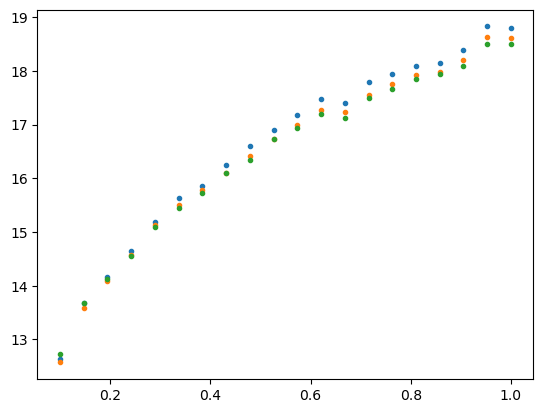

In [117]:
def test_simulate_mag():
    nsn = 20
    dm_int = 0.1
    cosmo = jc.Planck15()
    zs = numpy.linspace(0.1,1,nsn)
    Avs = numpy.zeros(nsn)
    # Avs = numpy.random.uniform(0,0.1,nsn)
    Rvs = numpy.zeros(nsn)+3.1
    efflam = numpy.array([4700., 6420.,  7849.])
    dlams = numpy.zeros(len(efflam))
    fwidth = numpy.zeros(len(efflam))
    dm_obs = numpy.zeros((nsn,len(efflam)))+0.02
    # mag = simulate_mag(zs, Avs, Rvs, dm_int, cosmo, dm_obs, efflam )
    # mag_lam(efflam, Avs, Rvs, zs, cosmo)
    # lnL_mag_survey(cosmo.Omega_c,cosmo.w0, cosmo.wa, dm_int, Avs, Rvs, 
    #                           dlams, fwidth, zs ,mag, dm_obs, efflam)
    plt.plot(zs, simulate_mag(zs, Avs, Rvs, dm_int, cosmo, dm_obs, efflam )[:,:,0],'.')

test_simulate_mag()

In [118]:
Finv = jnp.linalg.inv(F)

In [69]:
Finv

Array([[ 1.17628317e+00, -3.48577430e+00, -1.94584053e-01,
        -2.13552030e-01, -2.55983918e-01, -2.80114587e-01,
        -2.71155632e-01, -3.09791508e-01, -3.06446131e-01,
        -2.86283176e-01, -2.61612959e-01, -2.51864615e-01,
        -2.40414421e-01, -2.17365714e-01, -1.93600020e-01,
        -1.67632629e-01, -1.49901134e-01, -1.15332130e-01,
        -8.73844629e-02, -9.18807739e-02, -6.42486043e-02,
        -4.34433711e-02, -9.34075711e+01, -7.89001382e+01,
        -6.15418301e+01],
       [-3.48577430e+00,  1.08793649e+01,  6.61620745e-01,
         7.46246377e-01,  8.74881827e-01,  9.58649014e-01,
         9.66135344e-01,  1.08460035e+00,  1.06217797e+00,
         1.01199158e+00,  9.20039084e-01,  9.16004905e-01,
         8.86912129e-01,  7.95820851e-01,  7.51231588e-01,
         6.57478296e-01,  6.07191613e-01,  5.01649204e-01,
         4.06375956e-01,  4.15831715e-01,  3.29147722e-01,
         2.63054688e-01,  3.38708554e+02,  2.62529467e+02,
         1.72747267e+02],
    

In [19]:
zs, flux, dflux, efflam, Avs, Rvs, dm_int, cosmo = simulate_flux()

In [20]:
lnL(cosmo.Omega_c,cosmo.w0, cosmo.wa, dm_int, Avs, Rvs, 0., 1., zs ,flux, dflux, efflam)

Array(23.15354548, dtype=float64)

In [21]:
partials = partiallnL(cosmo.Omega_c,cosmo.w0, cosmo.wa, dm_int, Avs, Rvs, 0., 1., zs ,flux, dflux, efflam)
print(partials)
print(jnp.hstack(partials))

(Array(-55.46719433, dtype=float64, weak_type=True), Array(-17.24443358, dtype=float64, weak_type=True), Array(-3.58683238, dtype=float64, weak_type=True), Array(-446.57654685, dtype=float64, weak_type=True), Array([ -9.67880591, -41.84293814,   6.33656222, -11.90046755,
       -20.70561905,  38.04189149,   5.14860007,   1.94222588,
        15.86013058,  19.85769896], dtype=float64))
[ -55.46719433  -17.24443358   -3.58683238 -446.57654685   -9.67880591
  -41.84293814    6.33656222  -11.90046755  -20.70561905   38.04189149
    5.14860007    1.94222588   15.86013058   19.85769896]


In [15]:
hessianlnL(cosmo.Omega_c,cosmo.w0, cosmo.wa, dm_int, Avs, Rvs, 0., 1., zs ,flux, dflux, efflam)

Array(1201.42576679, dtype=float64, weak_type=True)

In [19]:
zs, flux, dflux, efflam, Avs, Rvs, dm_int, cosmo = simulate_flux(nsn=100)

In [24]:
dflux

array([[[1.39402158e-06],
        [9.49390326e-07],
        [6.41613781e-08]],

       [[3.26184075e-07],
        [2.15639808e-07],
        [2.30748393e-08]],

       [[1.58766705e-07],
        [1.08657878e-07],
        [1.04668614e-08]],

       [[7.56272506e-08],
        [5.42916555e-08],
        [6.46344020e-09]],

       [[4.02978119e-08],
        [3.87828165e-08],
        [5.06665019e-09]],

       [[2.58672030e-08],
        [3.03237377e-08],
        [4.21967867e-09]],

       [[2.03202517e-08],
        [1.74392100e-08],
        [2.64399000e-09]],

       [[1.31675557e-08],
        [1.57031436e-08],
        [2.94445990e-09]],

       [[1.30241081e-08],
        [1.37460348e-08],
        [2.31766052e-09]],

       [[8.07006731e-09],
        [1.12925992e-08],
        [2.28930701e-09]],

       [[7.68955913e-09],
        [8.16702159e-09],
        [1.90278734e-09]],

       [[4.68076501e-09],
        [7.92331387e-09],
        [1.64880372e-09]],

       [[4.39891480e-09],
        [6.593

<ErrorbarContainer object of 3 artists>

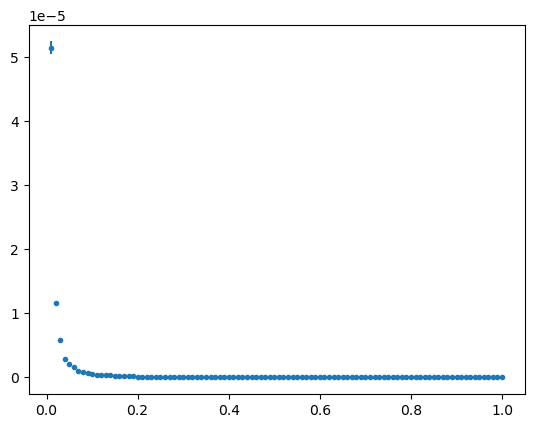

In [27]:
plt.errorbar(zs[:,None],flux[:,1,0],dflux[:,1,0],fmt='.')

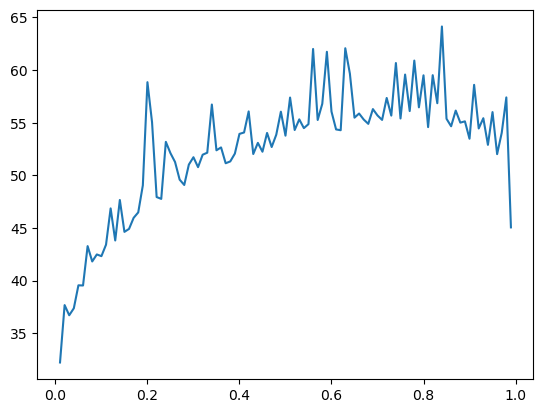

In [66]:
plt.plot(zs, -2.5*numpy.log(flux_sn(5000,Avs,Rvs,zs,cosmo)))

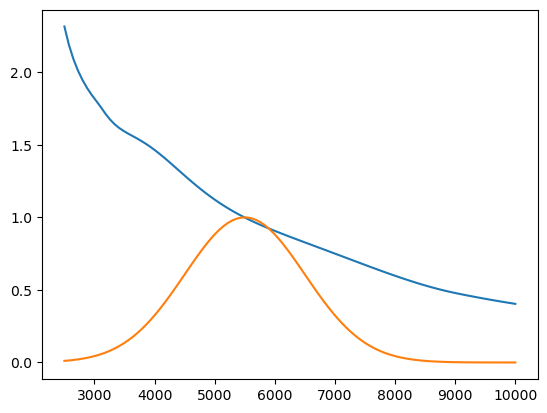

In [55]:
plt.plot(wl,CCM(wl,3.1))
plt.plot(wl,L_sn(wl))